## This code reads packetloss data for one site and runs anomaly detection on it. This version made for running in kubernetes.

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

from time import time

import numpy as np
import pandas as pd

# import tensorflow as tf - should do it by itself

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split

from pandas.tseries.offsets import *

Using TensorFlow backend.


### parameters
These should not change for one version (_type) of test. 

In [2]:
alarm_index = 'ps_alarms'
alarm_type = 'NN v1'

ref = 24
sub = 1
ref = ref * Hour()
sub = sub * Hour()

## get a job from ES
it takes one job earlies it time.
it shouls also consider jobs that are "pending" but for too long.

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

my_query = {
    "size": 1,
    "query":{
       "bool":{
            "must":[
                {"term" : { "processed" : "no" }},
                {"term" : { "_type" : alarm_type }}
            ]
        }
    },
    "sort" : [
      {"timestamp" : {"order" : "asc"}}
    ]
}


res = es.search(index=alarm_index, body=my_query, request_timeout=120)
#print(res)
job_id = res['hits']['hits'][0]['_id']
job_source = res['hits']['hits'][0]['_source']
job_timestamp = job_source['timestamp']
site = job_source['site']
endpoint = job_source['endpoint']
print ('Processing id:',job_id, '\ttimebin:', job_timestamp, '\tsite:', site, '\tendpoint:', endpoint)

Processing id: AV70Dm7WGhjWlH-aShk- 	timebin: 20171005T230000Z 	site: GRIF 	endpoint: 134.158.73.243


### setting a lock on the job

In [4]:
es.update(index=alarm_index, doc_type=alarm_type, id=job_id, body={"doc": {"processed": "pending"}})

{'_id': 'AV70Dm7WGhjWlH-aShk-',
 '_index': 'ps_alarms',
 '_shards': {'failed': 0, 'successful': 2, 'total': 2},
 '_type': 'NN v1',
 '_version': 2,
 'result': 'updated'}

### Getting actual perfsonar data

In [5]:
end = pd.Timestamp(job_timestamp)
start = end - ref - sub
print('start:', start, '\tend:', end)

indices = "network_weather-2017.*"

my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': start.strftime('%Y%m%dT%H%M00Z'), 'lt': end.strftime('%Y%m%dT%H%M00Z')}}},
                    {'bool':
                        {'should':[
                            {'term': {'src': endpoint}},
                            #{'term': {'src': srcSiteThroughputServer}},
                            #{'term': {'src': destSiteOWDServer}},
                            #{'term': {'src': destSiteThroughputServer}}
                        ]}
                    },
                    {'bool':
                        {'should':[
                            {'term': {'_type': 'packet_loss_rate'}},
                            #{'term': {'_type': 'latency'}},
                            #{'term': {'_type': ''}},
                            #{'term': {'_type': ''}}
                        ]}
                    }
                
                   ]
            }
        }
    }


scroll = scan(client=es, index=indices, query=my_query)

start: 2017-10-04 22:00:00+00:00 	end: 2017-10-05 23:00:00+00:00


### scan the data

In [6]:
count = 0
allData={} # will be like this: {'dest_host':[[timestamp],[value]], ...} 
for res in scroll:
#     if count<2: print(res) 
    if not count%100000: print(count)
    if count>1000000: break
    dst = res['_source']['dest'] # old data - dest, new data - dest_host
    if dst not in allData: allData[dst]=[[],[]]
    allData[dst][0].append(res['_source']['timestamp'] )
    allData[dst][1].append(res['_source']['packet_loss'])
    
    count=count+1

dfs=[]
for dest,data in allData.items():
    ts=pd.to_datetime(data[0],unit='ms')
    df=pd.DataFrame({dest:data[1]}, index=ts )
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda t: t.replace(second=0))
    df = df[~df.index.duplicated(keep='last')]
    dfs.append(df)
    #print(df.head(2))
print('docs read:', count)

0
100000
docs read: 137609


In [8]:
full_df = pd.concat(dfs, axis=1)
print(full_df.shape)
# full_df.head()
#print(full_df.columns )

(1500, 90)


#### plot timeseries

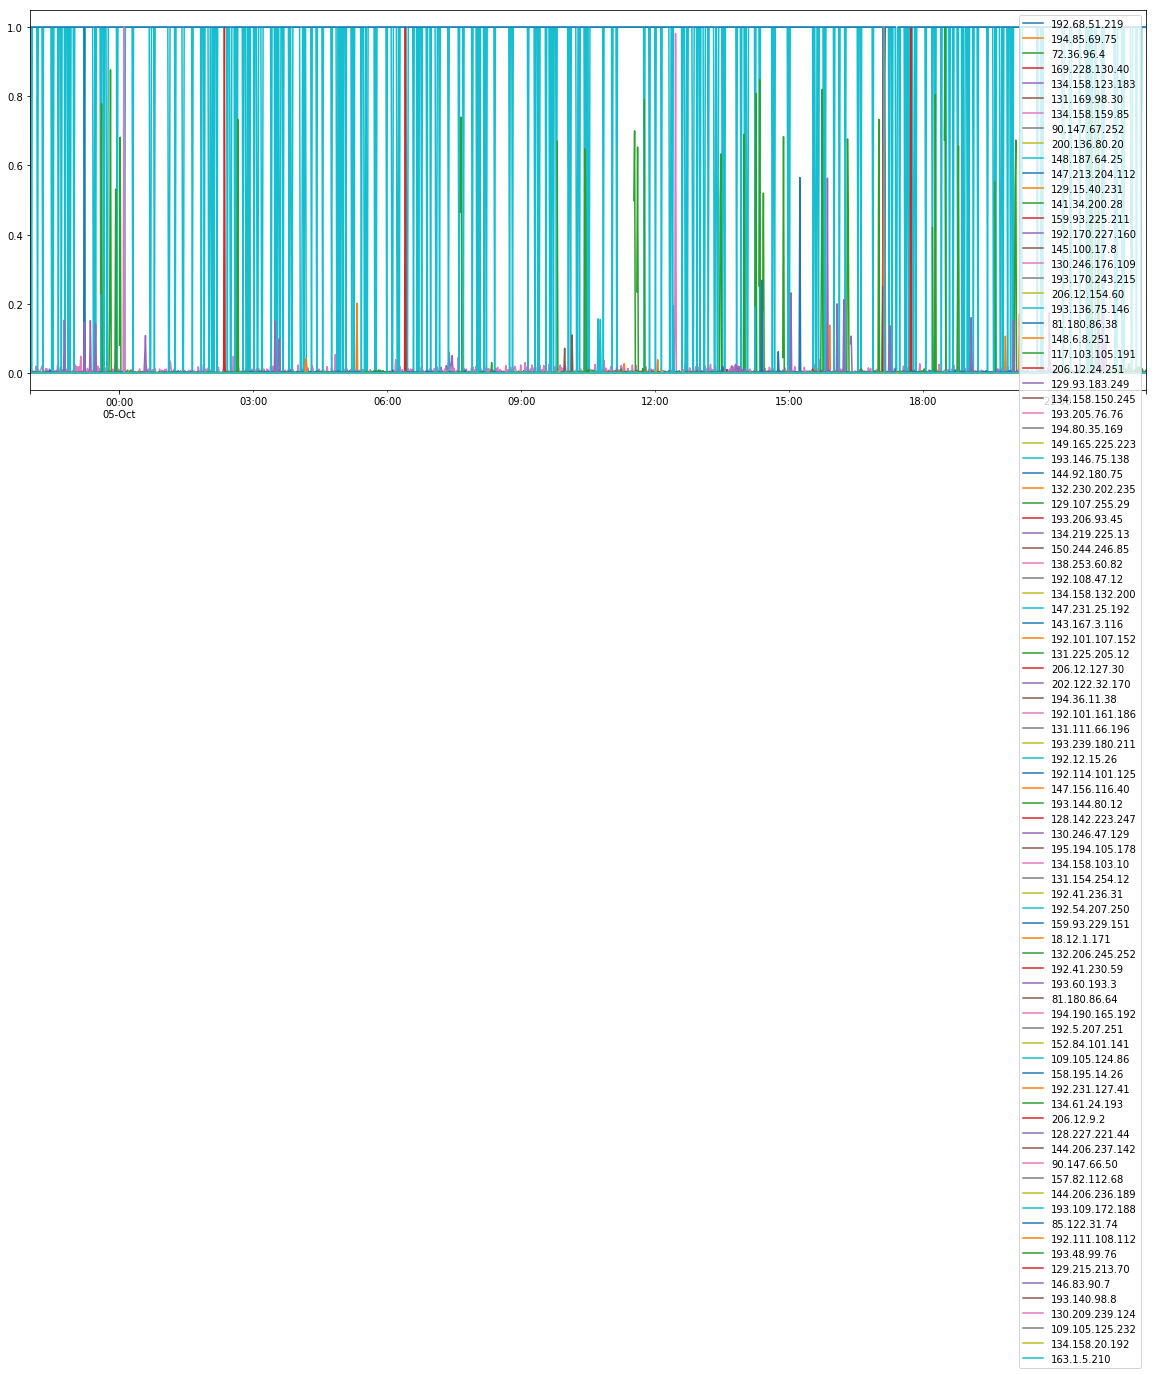

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
full_df.plot(figsize=(20,7))

### create Network Model

In [10]:
class ANN(object):
    def __init__(self, n_series):
        self.n_series = n_series
        self.df = None
        self.auc_df = None
        
        self.nn = Sequential()
        self.nn.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=n_series, activation='relu'))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=1, activation='sigmoid'))
#       self.nn.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#       self.nn.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        self.nn.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#       self.nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        self.nn.summary()
    
    def set_data(self, df):
        self.df = df
    
    def plot_hist(self, hist):
        es=len(hist.history['loss'])
        x = np.linspace(0,es-1,es)
        plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
        plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
        plt.legend()
        plt.show()
    
    def check_for_anomaly(self):
    
        lstart = self.df.index.min()
        lend = self.df.index.max()

        #round start 
        lstart.seconds=0
        lstart.minutes=0
        print(lstart, lend)
        
        ti = lstart + ref
        
        startt = time()
        
        ref_df = self.df[ (self.df.index < ti)]
        sub_df = self.df[(self.df.index >= ti)]
    
        y_ref = pd.Series([0] * ref_df.shape[0])
        X_ref = ref_df
    
        y_sub = pd.Series([1] * sub_df.shape[0])
        X_sub = sub_df
        
        # separate Reference and Subject into Train and Test
        X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
        # combine training ref and sub samples
        X_train = pd.concat([X_ref_train, X_sub_train])
        y_train = pd.concat([y_ref_train, y_sub_train])

        # combine testing ref and sub samples
        X_test = pd.concat([X_ref_test, X_sub_test])
        y_test = pd.concat([y_ref_test, y_sub_test])
    
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
    
        X_train_s, y_train_s = shuffle(X_train, y_train)
    
        hist = self.nn.fit(X_train_s.values, y_train_s.values, epochs=100, verbose=0, shuffle=True, batch_size=10)
        loss_and_metrics = self.nn.evaluate(X_test.values, y_test.values)#, batch_size=256)
        print(loss_and_metrics)
    
        self.plot_hist(hist)
    
        print('\n',ti,"\trefes:" , ref_df.shape, "\tsubjects:", sub_df.shape, '\taccuracy:', score)
        
        print("took:", time()-startt)
    
        return scaled_accuracy(loss_and_metrics[1], ref_df.shape[0], sub_df.shape[0])


#### functions

In [11]:
def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()
    
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    chance = float(ref_samples)/(ref_samples+sub_samples)
    print('chance:', chance)
    print('actual accuracy:', accuracy)
    rescale = 1/(1 - chance)
    return (accuracy-chance)*rescale


### fix NANs

In [12]:
# full_df = full_df.interpolate(method='time', axis=0)  #these don't work for some reason...
# full_df.interpolate(method='nearest', axis=0, inplace=True)
full_df.fillna(0, inplace=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               16380     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                16290     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 91        
Total params: 32,761
Trainable params: 32,761
Non-trainable params: 0
_________________________________________________________________
2017-10-04 22:00:00 2017-10-05 22:59:00
 32/450 [=>............................] - ETA: 0s[0.12046269019444783, 0.96666666666666667]


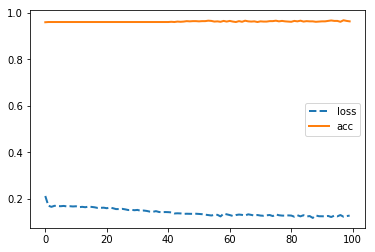

NameError: name 'score' is not defined

In [14]:
ann = ANN(full_df.shape[1])
ann.set_data(full_df)
rescaled_accuracy = ann.check_for_anomaly()

#### Update state and value

In [ ]:

es.update(index=alarm_index, doc_type=alarm_type, id=job_id, body={"doc": {"processed": "yes", "rescaled":rescaled_accuracy}})